In this notebook, I aim to answer:

- Data exploration – What are the most interesting features of the data set? What have you considered and why have you made the decisions you have done?
- Modelling – What process did you follow when modelling sales?  How have you designed your model and what did you account for?
- Conclusions – What are your main findings? How might you use those insights, or your model, to improve Hastings’ pricing? What else would it have been useful to know?

Useful notes: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [35]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from numpy import mean, std
# from numpy import std
# from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from lightgbm import LGBMClassifier
# plt.rcParams["figure.figsize"] = (10,10)

In [2]:
df=pd.read_csv('data/data.csv')
display(df.head(3))

# add id col and exposure
df['row_num'] = np.arange(len(df))
df['Exposure'] = 1

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,29/05/2016,M,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,03/07/2015,S,0
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,04/10/2015,M,0


# Data Partitioning

In [3]:
# define training / validation 
# .drop(['Sale'], axis=1)
training_df, validation_df, response_training_df, response_validation_df = train_test_split(df, df['Sale'], test_size=0.2, random_state=1)

In [4]:
# Null Accuracy Score in dataset, training and test
lst = [0] * len(df['Sale'])
print('Dataset Null Accuracy Score:', accuracy_score(df['Sale'],pd.Series(lst)))

lst = [0] * len(response_training_df)
print(f'Training Null Accuracy Score: {accuracy_score(response_training_df, pd.Series(lst))}')

lst = [0] * len(response_validation_df)
print(f'Test Null Accuracy Score: {accuracy_score(response_validation_df, pd.Series(lst))}')

Dataset Null Accuracy Score: 0.30202
Training Null Accuracy Score: 0.299975
Test Null Accuracy Score: 0.3102


# EDA

In [5]:
# duplicates
print(df.shape)
print(df.drop_duplicates().shape)

(50000, 12)
(50000, 12)


In [6]:
# constant cols when sale=1 or 0

In [7]:
# missing
percent_missing = df.isnull().sum() * 100 / len(df)
number_missing = df.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                 'number_missing':number_missing})

display(missing_value_df)

,column_name,percent_missing,number_missing
Driver_Age,Driver_Age,0.988,494
Vehicle_Value,Vehicle_Value,1.018,509
Tax,Tax,0.962,481
Price,Price,0.992,496
Vehicle_Mileage,Vehicle_Mileage,1.072,536
Credit_Score,Credit_Score,1.044,522
Licence_Length_Years,Licence_Length_Years,0.984,492
Date,Date,0.000,0
Marital_Status,Marital_Status,0.976,488
Sale,Sale,0.000,0


In [8]:
# missing values

missing_numerics=['Driver_Age',
 'Vehicle_Value',
 'Tax',
 'Price',
 'Vehicle_Mileage',
 'Credit_Score',
 'Licence_Length_Years']

for i in missing_numerics:
    training_df[i]=training_df[i].fillna(training_df[i].mean())
    validation_df[i]=validation_df[i].fillna(validation_df[i].mean())
    
missing_categorics=['Marital_Status']

for i in missing_categorics:
    
    training_df[i]=training_df[i].fillna('MI')
    validation_df[i]=validation_df[i].fillna('MI')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [9]:
# Feature Engineering

def feature_engineering(df):
    
    # Year Licence obtained
    # Partitioned features
    # Average Credit score per licence length

    # date columns
    df['Year']=pd.to_datetime(df['Date']).dt.year
    df['Month']=pd.to_datetime(df['Date']).dt.month_name()
    df['Day']=pd.to_datetime(df['Date']).dt.day_name()
    df['Year_Month']=pd.to_datetime(df['Date']).dt.year.astype(str)+pd.to_datetime(df['Date']).dt.month.astype(str).str.zfill(2)

    # age_licence_obtained
    df['age_licence_obtained']=round(df['Driver_Age']-df['Licence_Length_Years'],2)
    df['per_life_driving']=round(df['Licence_Length_Years']/df['Driver_Age'],2)
    
    return df

training_df=feature_engineering(training_df)
validation_df=feature_engineering(validation_df)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value i

In [10]:
# categoric cols
cat_cols=['Marital_Status']

# one hot encoding
for i in cat_cols:
    for j in training_df[i].unique():
        training_df[str(i)+'_'+str(j)]=np.where(training_df[i].astype(str)==j,1,0)
        
    for k in validation_df[i].unique():
        validation_df[str(i)+'_'+str(k)]=np.where(validation_df[i].astype(str)==k,1,0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# response mean encoding
mean_cols=['Year_Month', 'Day']

def mean_encoder(training_df, validation_df, col, response):

    """ function to mean encode categorical features 
        any missing values are imputed with mode """

    # Create dictionary
    mean_encoding=training_df.groupby(col)[response].mean().to_dict()

    # Apply to train
    training_df[col+'_ME']=training_df[col].replace(mean_encoding)
    training_df[col+'_ME']=training_df[col+'_ME'].fillna(training_df[col+'_ME'].mode()[0])

    # Apply to valid
    validation_df[col+'_ME']=validation_df[col].replace(mean_encoding)
    validation_df[col+'_ME']=validation_df[col+'_ME'].fillna(validation_df[col+'_ME'].mode()[0])        

for i in mean_cols:
    mean_encoder(training_df, validation_df, i, 'Sale')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [12]:
# Correlated Cols

# Visualisation

In [13]:
# def plot_one_ways(i, diff_band, exposure, obs, target_name, width=0.5):
    
#     """
#     function to create one way plots
#     - diff_band: the x co-ordinates for plots
#     - exposure: number of rows per diff_band grouping
#     - width: width of columns predefined as 0.5
#     - target_name: response to plot as line
#     """
    
#     plt.bar(diff_band, exposure, width, color='gold', label='Diff', edgecolor='k')
#     plt.xticks(rotation=90)
#     plt.ylim(0, max(exposure)*3)
#     plt.ylabel('Exposure')
#     plt.xlabel(f'{i}')
#     plt.title(f'One Way Plot of {i}')

#     # Line plot
#     axes2 = plt.twinx()
#     axes2.plot(diff_band, obs, color='fuchsia', marker="s", markeredgecolor='black', label='Actual')
#     axes2.set_ylabel(target_name)

#     # legend and settings
#     plt.legend(loc="upper left")

#     plt.show()

In [14]:
# i='Vehicle_Value'
# target_name='Sale'

# # Plot Original
# df[i]=df[i].fillna(-1)
# exposure=df.groupby(i)['Exposure'].sum()
# obs=df.groupby(i)[target_name].mean()
# diff_band=sorted(set(df[i]))
# plot_one_ways(i, diff_band, exposure, obs, target_name)

# Modelling Inputs

In [15]:
cols=['Driver_Age',
 'Vehicle_Value',
 'Tax',
 'Price',
 'Vehicle_Mileage',
 'Credit_Score',
 'Licence_Length_Years',
#  'Date',
#  'Marital_Status',
#  'Sale',
#  'row_num',
#  'Exposure',
#  'Year',
#  'Month',
#  'Day',
#  'Year_Month',
 'age_licence_obtained',
 'per_life_driving',
 'Marital_Status_S',
 'Marital_Status_M',
 'Marital_Status_D',
 'Marital_Status_MI',
 'Year_Month_ME',
 'Day_ME']

# Baseline Model

In [ ]:
# add constant columns for baseline model using df original factors

In [22]:
# Logistic Regression
logistic_model=LogisticRegression(max_iter=5000)

# define standard scaler
scaler = StandardScaler()

# transform train data
train_scaled = scaler.fit_transform(training_df[cols])

#Fit the model:
logistic_model.fit(train_scaled,response_training_df)

# transform valid
valid_scaled=scaler.transform(validation_df[cols])

#Make predictions on training set
train_predictions = logistic_model.predict(train_scaled)
valid_predictions = logistic_model.predict(valid_scaled)

#Print accuracy
accuracy = metrics.accuracy_score(train_predictions,response_training_df)
print("Training Accuracy : %s" % "{0:.3%}".format(accuracy))
accuracy = metrics.accuracy_score(valid_predictions,response_validation_df)
print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

f1=f1_score(response_training_df, train_predictions, average=None)
print(f'Training F1 Score: {f1}')
f1=f1_score(response_validation_df, valid_predictions, average=None)
print(f'Validation F1 Score: {f1}')

Training Accuracy : 87.772%
Validation Accuracy : 87.410%
Training F1 Score: [0.78772623 0.91413122]
Validation F1 Score: [0.78801145 0.91046156]


# Modelling

In [23]:
# elastic_net_model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 1, max_iter=5000)

# # define standard scaler
# scaler = StandardScaler()

# # transform train data
# train_scaled = scaler.fit_transform(training_df[cols])

# #Fit the model:
# elastic_net_model.fit(train_scaled,response_training_df)

# # transform valid
# valid_scaled=scaler.transform(validation_df[cols])

# # make predictions on training set:
# predictions = elastic_net_model.predict(valid_scaled)

# # print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [24]:
# # decision tree
# tree_model = DecisionTreeClassifier()

# #Fit the model:
# tree_model.fit(training_df[cols],response_training_df)

# #Make predictions on training set
# predictions = tree_model.predict(validation_df[cols])

# #Print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [27]:
# Random Forest
rf_model = RandomForestClassifier() # n_estimators=100,min_samples_split=25, max_depth=7, max_features=2

#Fit the model
rf_model.fit(training_df[cols],response_training_df)

#Make predictions on training set
predictions = rf_model.predict(validation_df[cols])

#Print accuracy
accuracy = metrics.accuracy_score(predictions,response_validation_df)
print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

f1=f1_score(response_validation_df, predictions, average=None)
print(f'Validation F1 Score: {f1}')

Validation Accuracy : 88.320%
Validation F1 Score: [0.80343319 0.91691564]


https://www.kaggle.com/virajbagal/eda-xgb-random-forest-parameter-tuning-hyperopt

In [29]:
# XGBoost
xgb_model = XGBClassifier()

# Fit the model
xgb_model.fit(training_df[cols],response_training_df)

#Make predictions on training set
predictions = xgb_model.predict(validation_df[cols])

#Print accuracy
accuracy = metrics.accuracy_score(predictions,response_validation_df)
print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

f1=f1_score(response_validation_df, predictions, average=None)
print(f'Validation F1 Score: {f1}')

Validation Accuracy : 88.420%
Validation F1 Score: [0.80485339 0.91767382]


In [ ]:
# from sklearn.svm import SVC  

# # Instantiate the Support Vector Classifier (SVC)
# svc = SVC(C=1.0, random_state=1, kernel='linear', class_weight='balanced')

# # define standard scaler
# scaler = StandardScaler()

# # transform train data
# train_scaled = scaler.fit_transform(training_df[cols])

# #Fit the model:
# svc.fit(train_scaled,response_training_df)

# # transform valid
# valid_scaled=scaler.transform(validation_df[cols])

# #Make predictions on training set:
# predictions = svc.predict(valid_scaled)

# #Print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [ ]:
# # compare standalone models for binary classification
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from matplotlib import pyplot
 
# # get the dataset
# # def get_dataset():
# # 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# # 	return X, y

# X=training_df[cols]
# y=response_training_df

# # get a list of models to evaluate
# def get_models():
#     models = dict()
#     models['lr'] = LogisticRegression()
#     models['knn'] = KNeighborsClassifier()
#     models['cart'] = DecisionTreeClassifier()
# #     models['svm'] = SVC()
#     models['bayes'] = GaussianNB()
#     models['rforest'] = RandomForestClassifier()
#     models['xgb'] = XGBClassifier()
#     return models
 
# # evaluate a given model using cross-validation
# def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
#     return scores
 
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

# Stacking

In [36]:
# inputs
X=training_df[cols]
y=response_training_df
X_valid=validation_df[cols]
y_valid=response_validation_df

# get a stacking ensemble of models
def get_stacking():
    
    # define the base models
    level0 = list()
#     level0.append(('lr', LogisticRegression()))
#     level0.append(('knn', KNeighborsClassifier()))
#     level0.append(('cart', DecisionTreeClassifier()))
#     level0.append(('svm', SVC()))
#     level0.append(('bayes', GaussianNB()))
    level0.append(('rforest', RandomForestClassifier()))
    level0.append(('xgb', XGBClassifier()))
    level0.append(('lgbm', LGBMClassifier()))    
    
    # define meta learner model
    level1 = LogisticRegression()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
#     models['knn'] = KNeighborsClassifier()
#     models['cart'] = DecisionTreeClassifier()
#     models['svm'] = SVC()
#     models['bayes'] = GaussianNB()
    models['rforest'] = RandomForestClassifier()
    models['xgb'] = XGBClassifier()
    models['lgbm'] = LGBMClassifier()
#     models['lgbm'] = LGBMClassifier()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y, X_valid, y_valid):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    valid_scores = cross_val_score(model, X_valid, y_valid, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return scores, valid_scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
valid_results, valid_names = list(), list()
for name, model in models.items():
    scores, valid_scores = evaluate_model(model, X, y, X_valid, y_valid)
    results.append(scores)
    valid_results.append(valid_scores)
    names.append(name)
    valid_names.append(name)
    print(name, 'training:', round(mean(scores),3), round(std(scores),3))
    print(name, 'valid:', round(mean(valid_scores),3), round(std(valid_scores),3))

lr training: 0.911 0.004
lr valid: 0.906 0.009
rforest training: 0.92 0.005
rforest valid: 0.914 0.009
xgb training: 0.92 0.002
xgb valid: 0.911 0.006
lgbm training: 0.923 0.004
lgbm valid: 0.914 0.007
stacking training: 0.922 0.004
stacking valid: 0.916 0.007


# Review Performance

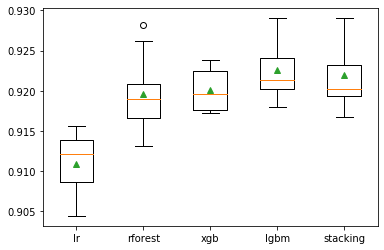

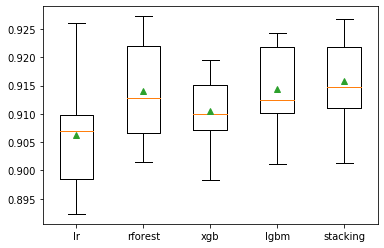

In [37]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# plot model performance for comparison
pyplot.boxplot(valid_results, labels=valid_names, showmeans=True)
pyplot.show()

# Conclusions

In [39]:
for name, model in models.items():
    print(name, model)

lr LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
rforest RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
xgb XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsam

In [ ]:
# add training validation and test
# what is missing?
# vehicle value at new / vehicle value when bought
# claims history
# occupation
# geographical factors
# exposure period
# telematics
# excess
# gender
# Age
# id column / identifier
# time of quote
# difference in live data vs modelled data
# selection biases
# which features can be used for modelling based on protected characteristics?
# are there any duplicaste quotes which we don't know about?